In [2]:
from pathlib import Path

import geopandas as gpd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

from data import constants
from data.eluc_data import ELUCData
import experiments.utils as utils
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prsdk.persistence.serializers.sklearn_serializer import SKLearnSerializer
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic, NoCropHeuristic
from predictors.percent_change.percent_change_predictor import PercentChangePredictor
from predictors.percent_change.crop_change_predictor import CropChangePredictor

In [36]:
RESULTS_DIR = Path("prescriptors/nsga2/training_runs/eds-crop")
FIGURE_DIR = Path("experiments/figures/eds")
OUTCOMES = ["ELUC", "change", "cropchange"]

dataset = ELUCData.from_hf()
encoder = dataset.encoder

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

In [4]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
cropchange_predictor = CropChangePredictor()
predictors = {"ELUC": nnp, "change": change_predictor, "cropchange": cropchange_predictor}

crop_results = utils.heuristics.evaluate_experiment(RESULTS_DIR, 100, context_df, encoder, OUTCOMES, predictors, old=True)

100%|██████████| 544/544 [03:42<00:00,  2.45it/s]


In [5]:
pcts = [i / 100 for i in range(0, 101)]

linreg_serializer = SKLearnSerializer()
linreg = linreg_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-linreg"))
coefs = linreg.model.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

even_manager = PrescriptorManager({str(pct): EvenHeuristic(pct, "secdf") for pct in pcts}, predictors)
perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)
no_crop_manager = PrescriptorManager({str(pct): NoCropHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [6]:
even_results = utils.heuristics.evaluate_prescriptors(even_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)
perfect_results = utils.heuristics.evaluate_prescriptors(perfect_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)
no_crop_results = utils.heuristics.evaluate_prescriptors(no_crop_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)

100%|██████████| 101/101 [00:25<00:00,  3.98it/s]


In [33]:
def plot_cropchange(ax: plt.Axes, crop_results: pd.DataFrame, perfect_results: pd.DataFrame, no_crop_results: pd.DataFrame, verbose=False):
    close_cand_ids = [utils.heuristics.closest_cand_id(perfect_results, change) for change in crop_results["change"]]
    perfect_cropchanges = [perfect_results[perfect_results["cand_id"] == cand_id]["cropchange"].values[0] for cand_id in close_cand_ids]

    cropchange_diff = crop_results["cropchange"] - perfect_cropchanges

    minmax = np.abs(cropchange_diff).max()
    norm = TwoSlopeNorm(vmin=minmax * -1, vcenter=0, vmax=minmax)

    non_dom = crop_results.apply(lambda row: utils.heuristics.check_non_dominated(row, perfect_results, ["change", "ELUC"]), axis=1)
    non_dom_diff = non_dom & (cropchange_diff < 0)

    ax.plot(no_crop_results["change"], no_crop_results["ELUC"], label="No Crop Heuristic", color="orange", linestyle="--")
    ax.plot(perfect_results["change"], perfect_results["ELUC"], label="Perfect Heuristic", color="lightgreen", linestyle="--")

    ax.scatter(crop_results[~non_dom_diff]["change"], crop_results[~non_dom_diff]["ELUC"], label="Evolved Prescriptors", c=cropchange_diff[~non_dom_diff], cmap="PiYG_r", norm=norm)
    ax.scatter(crop_results[non_dom_diff]["change"], crop_results[non_dom_diff]["ELUC"], label="Outperforms & Less Crop", c=cropchange_diff[non_dom_diff], cmap="PiYG_r", edgecolors="black", norm=norm)

    mappable = ScalarMappable(norm=norm, cmap="PiYG_r")
    ax.figure.colorbar(mappable, label="Crop Change Difference", ax=ax)
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC")
    ax.legend()
    ax.set_title("a) Pareto Front of Crop Change-Minimizing Prescriptors")
    

    if verbose:
        print(crop_results[non_dom_diff])

    return ax

          ELUC    change  cropchange cand_id
8   -24.915731  0.416745    0.100658   16_50
47  -14.424579  0.196612    0.065170   38_19
53   -8.113581  0.101241    0.046822   40_96
54  -22.057487  0.339881    0.097792   40_17
79  -13.154452  0.171707    0.070616    44_0
83  -20.647125  0.311403    0.093477   44_99
89  -24.466312  0.404415    0.100480   45_46
160 -16.412680  0.235479    0.070094   55_76
163 -16.788172  0.225914    0.081373    56_1
164 -17.507420  0.249823    0.087623   56_38
174 -21.103456  0.319975    0.096244   57_61
214 -15.993813  0.218350    0.080827   61_12
238 -21.624399  0.329081    0.097135   64_98
249 -18.291475  0.262733    0.087014    65_4
253 -24.913841  0.416443    0.100755   66_12
258 -12.872603  0.170489    0.070316   66_29
271 -22.856201  0.361597    0.099775   68_82
277 -22.140896  0.343339    0.097886    69_2
296 -17.322193  0.247947    0.082400   71_65
301 -18.256081  0.252891    0.087190   71_56
307 -21.728466  0.334525    0.097061   72_22
309 -14.59

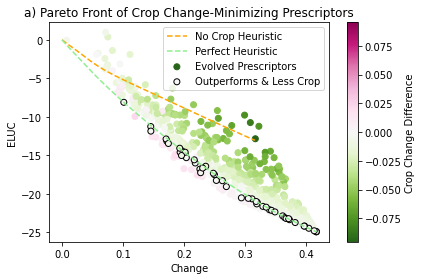

In [34]:
fig, ax = plt.subplots(tight_layout=True)
crop_sample = crop_results.sample(frac=0.1, random_state=42)
ax = plot_cropchange(ax, crop_results, perfect_results, no_crop_results, verbose=True)
plt.show()

In [15]:
crop_id = "44_0"
print(crop_results[crop_results["cand_id"] == crop_id])
even_id = utils.heuristics.closest_cand_id(even_results, crop_results[crop_results["cand_id"] == crop_id]["change"].values[0])
perfect_id = utils.heuristics.closest_cand_id(perfect_results, crop_results[crop_results["cand_id"] == crop_id]["change"].values[0])
no_crop_id = utils.heuristics.closest_cand_id(no_crop_results, crop_results[crop_results["cand_id"] == crop_id]["change"].values[0])
print(even_results[even_results["cand_id"] == even_id])
print(perfect_results[perfect_results["cand_id"] == perfect_id])
print(no_crop_results[no_crop_results["cand_id"] == no_crop_id])

         ELUC    change  cropchange cand_id
79 -13.154452  0.171707    0.070616    44_0
         ELUC   change  cropchange cand_id
31 -10.954629  0.17404    0.045089    0.31
         ELUC   change  cropchange cand_id
31 -12.948947  0.17404    0.071178    0.31
       ELUC    change  cropchange cand_id
36 -7.87119  0.173244         0.0    0.36


In [17]:
crop_manager = utils.heuristics.create_experiment_manager(RESULTS_DIR, 100, predictors, encoder, OUTCOMES, old=True)
crop_cao = utils.heuristics.trained_prescribe_and_predict(crop_manager, crop_id, context_df)
even_cao = utils.heuristics.trained_prescribe_and_predict(even_manager, even_id, context_df)
perfect_cao = utils.heuristics.trained_prescribe_and_predict(perfect_manager, perfect_id, context_df)
no_crop_cao = utils.heuristics.trained_prescribe_and_predict(no_crop_manager, no_crop_id, context_df)

In [20]:
def plot_avg_presc(ax: plt.Axes, cao_dfs: list[pd.DataFrame], plot_params: list[dict]):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(cao_dfs) + 1)
    for cao_df, params in zip(cao_dfs, plot_params):
        ax.bar(xticks + i * width, cao_df[constants.DIFF_RECO_COLS].mean(), width=width, **params)
        i += 1
    
    ax.set_xticks(xticks + (len(cao_dfs)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    ax.grid()
    ax.legend()
    ax.set_title("b) Average Recommendations Comparison")
    return ax

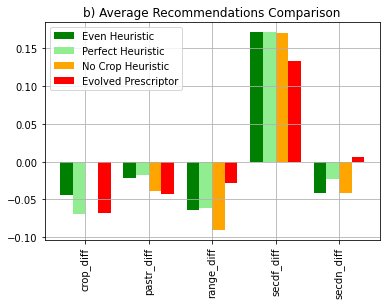

In [39]:
avg_presc_params = [
    {"label": "Even Heuristic", "color": "green"},
    {"label": "Perfect Heuristic", "color": "lightgreen"},
    {"label": "No Crop Heuristic", "color": "orange"},
    {"label": "Evolved Prescriptor", "color": "red"}
]

fig, ax = plt.subplots()
ax = plot_avg_presc(ax, [even_cao, perfect_cao, no_crop_cao, crop_cao], avg_presc_params)
plt.show()

### Paper Figures

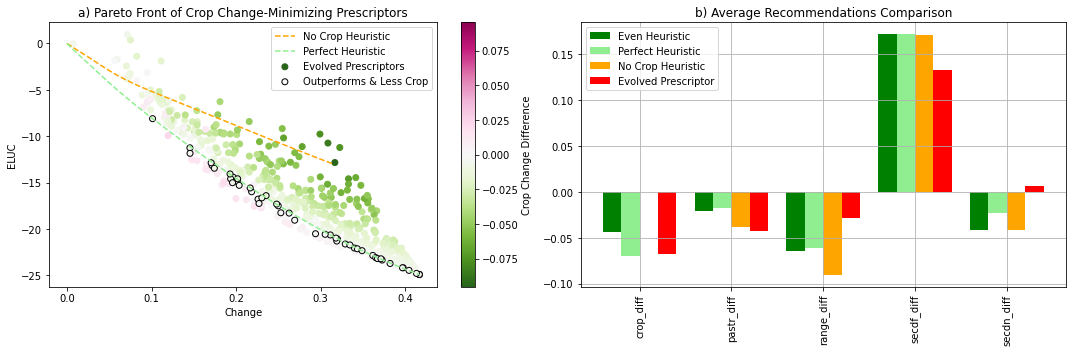

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axes[0] = plot_cropchange(axes[0], crop_results, perfect_results, no_crop_results)
axes[1] = plot_avg_presc(axes[1], [even_cao, perfect_cao, no_crop_cao, crop_cao], avg_presc_params)
# plt.savefig(FIGURE_DIR / "crop-fig.png", dpi=300, format="png")
plt.show()